# Анализ доходности приложения ProcrastinatePRO+

#  Описание проекта и данных

# Описание проекта:

Компания по приложению `Procrastinate Pro+`вкладывает огромные суммы денег в рекламу, но последние несколько месяцев терпит убытки. Моя задача — разобраться в причинах и помочь компании выйти в плюс.

***Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:***
*	лог сервера с данными об их посещениях,
*	выгрузка их покупок за этот период,
*	рекламные расходы.

***Предстоит изучить:***
*	откуда приходят пользователи и какими устройствами они пользуются,
*	сколько стоит привлечение пользователей из различных рекламных каналов;
*	сколько денег приносит каждый клиент,
*	когда расходы на привлечение клиента окупаются,
*	какие факторы мешают привлечению клиентов.



# Описание данных
Таблица `visits_log_short` (лог сервера с информацией о посещениях сайта):

* ***User Id*** — уникальный идентификатор пользователя
* ***Device*** — категория устройства пользователя
* ***Session start*** — дата и время начала сессии
* ***Session End*** — дата и время окончания сессии
* ***Channel*** — идентификатор рекламного источника, из которого пришел пользователь
* ***Region*** - страна пользователя

Таблица `orders_log_short` (информация о заказах):

* ***User Id*** — уникальный id пользователя, который сделал заказ
* ***Event Dt*** — дата и время покупки
* ***Revenue*** — выручка

Таблица `costs_short` (информация о затратах на маркетинг):

* ***Channel*** — идентификатор рекламного источника
* ***Dt*** — дата
* ***Costs*** — затраты на этот рекламный источник в этот день

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

from datetime import datetime, timedelta

from scipy import stats as st
import math

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go


## Шаг. Загрузка и подготовка данных
Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [2]:
visits = pd.read_csv('https://raw.githubusercontent.com/Ekaterina-Burdakova/analytics-course/master/datasets/visits_info_short.csv') # информация о посещении сайта
orders = pd.read_csv('https://raw.githubusercontent.com/Ekaterina-Burdakova/analytics-course/master/datasets/orders_info_short.csv') # информация о заказах
costs = pd.read_csv('https://raw.githubusercontent.com/Ekaterina-Burdakova/analytics-course/master/datasets/costs_info_short.csv') # информация о затратах на маркетинг


Посмотрим общую информацию об имеющихся датасетах и проверим есть ли явные дубликаты

In [3]:
visits.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [4]:
visits.info()
visits.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


0

In [5]:
orders.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [6]:
orders.info()
orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


0

In [7]:
costs.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [8]:
costs.info()
costs.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


0

* во всех таблицах приведем названия столбцов к нижнему регистру и "змеиному" виду;
* столбцы `visits['session_start']`, `visits['session_end']`, `orders['event_dt']` приведем к типу `datatime`, а `costs['dt']` приведем к дате;
* явных дубликатов не обнаружено.

In [9]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

In [10]:
orders.columns = ['user_id', 'event_dt', 'revenue']
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.dtypes

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

In [11]:
costs.columns = costs.columns.str.lower()
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.dtypes

dt          object
channel     object
costs      float64
dtype: object

### Вывод.
* заголовки столбцов приведены к нижнему регистру и "змеиному" виду;
* тип данных во всех колонках теперь соответствует значениям.

Переходим к следующему шагу

## Шаг. Задаем функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми мы познакомились в теоретических уроках.

In [12]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [13]:
 
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [15]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [18]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [19]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

## Шаг. Проведем исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### Создание пользовательских профилей

In [20]:
# для построения пользовательских профилей будем использовать функцию get_profiles
profiles = get_profiles(visits, orders, costs)
display (profiles.head(5))
print ("Минимальная дата привлечения пользователей -> ", profiles['first_ts'].min())
print ("Максимальная дата привлечения пользователей ->", profiles['first_ts'].max())

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

Минимальная дата привлечения пользователей ->  2019-05-01 00:00:41
Максимальная дата привлечения пользователей -> 2019-10-27 23:59:04


Пользовательские профили построены, даты привлечения соответствуют указанным в задании с 01.05.2019 по 27.10.2019.

Из анализа удалим клиентов `organic`, т.к. мы анализируем окупаемость рекламных инвестиций, а продажи клиентам  `organic` за привлечение которых компания не платила будут невольно улучшать в общей массе рекламные показатели, что может помешать нам правильно оценить картину.

In [21]:
#profiles = profiles.query("channel != 'organic'")

### Пользовательская география

In [22]:
# выведем проценты и округлим до двух знаков после запятой в python pandas
pd.options.display.float_format =lambda x:'{:.2%}'.format(x)

In [23]:
profiles.groupby('region').agg(
    {'user_id': 'nunique',
    'payer': ['sum', 'mean']}
).rename(columns={'user_id': 'unique_users', 'mean':'ratio'})

unique_users payer      
                   nunique   sum ratio
region                                
France               17450   663 3.80%
Germany              14981   616 4.11%
UK                   17575   700 3.98%
United States       100002  6902 6.90%

Львиную долю пользователей составляют клиенты из США, их 100 тыс. человек. Это более чем в 5 раз превышает количество пользователей из Франции, Германии и Великобритании. Доля платящих пользователей в США также самая высокая и составляет почти 7%, в Европейских странах этот показатель менее 4%. Интересно, что несмотря на более чем пятикратное превосходство в числе пользователей, доля платящих клиентов выше только чуть менее чем в два раза.

### Пользовательские устройства 

In [24]:
profiles.groupby('device').agg(
    {'user_id': 'nunique',
    'payer': ['sum', 'mean']}
).rename(columns={'user_id': 'unique_users', 'mean':'ratio'})

unique_users payer      
             nunique   sum ratio
device                          
Android        35032  2050 5.85%
Mac            30042  1912 6.36%
PC             30455  1537 5.05%
iPhone         54479  3382 6.21%

Большинство пользователей являются владельцами iPhone (54479), на втором месте с отставанием владельцы Android. Практически поровну владельцев MAC/PC. 

При этом интересно заметить, что доля платящих пользователей выше среди владельцев техники Apple (iPhone/MAC). Любители Apple платили примерно в чуть выше чем 6,3% случаях. Для владельцев Android это значение наблюдаем на уровне 5,85%, для PC 5,05%  



###  Источники привлечения

In [25]:
users_by_channel = profiles.groupby('channel').agg(
    {'user_id': 'nunique',
    'payer': ['sum', 'mean']}
).rename(columns={'user_id': 'unique_users', 'mean':'ratio'}).sort_values([('unique_users', 'nunique')], ascending = False)
users_by_channel

unique_users payer       
                        nunique   sum  ratio
channel                                     
organic                   56439  1160  2.06%
FaceBoom                  29144  3557 12.20%
TipTop                    19561  1878  9.60%
OppleCreativeMedia         8605   233  2.71%
LeapBob                    8553   262  3.06%
WahooNetBanner             8553   453  5.30%
RocketSuperAds             4448   352  7.91%
MediaTornado               4364   156  3.57%
YRabbit                    4312   165  3.83%
AdNonSense                 3880   440 11.34%
lambdaMediaAds             2149   225 10.47%

In [26]:
# отменяем стандарт оформления в процентах для float
pd.reset_option('^display.', silent=True)

Самый большой траффик мы получаем без специальных средств привлечения, но и доля платящих в `organic` самая низкая.
Явно выделяются источники `FaceBoom` c 12,2% платящих пользователей, `Tip Top` c 9.6%. Оба этих источника и привлекают наибольшее количество клиентов (если не учитывать organic конечно).
Стоит обратить внимание еще на `AdNonSense` и `lambdaMediaAds` которые хоть и являются "аутсайдерами" по привлечению пользователей, но зато имеют хороший процент конвертации их в плательщиков на уровне лидеров (11,34% и 10,47% соответственно). Не плохая конвертация еще у `RocketSuperAds` на уровне почти 8%. Остальные источники и привлекают ощутимо меньше и превращают в плательщиков менее 5% своего контингента.

### Вывод по шагу 3

На данном шаге мы построили пользовательские профили из имеющихся данных, а также убедились, что даты привлечения пользователей совпадают с указанными в задаче (с 01.05.2019 по 27.10.2019). Провели небольшой исследовательский анализ, который показал следующее:

* подавляющее большинство клиентов `Procrastinate Pro+` проживают в США;
* клиенты предпочитают пользоваться мобильными устройствами, в первую очередь iPhone;
* большинство платящих клиентов пользуются устройствами `Apple (MAC, iPhone)`;
* наибольшее количество траффика `Procrastinate Pro+`получает через `FaceBoom` и `TipTop`, конвертация пользователей в плательщиков через эти каналы также высокая (12,2% и 9,6% соответственно).
* аутсайдеры по привлечению клиентов `AdNonSense` и `lambdaMediaAds` показывают конвертацию пользователей в плательщики на уровне лидеров (11,34% и 10,47% соответственно), кроме этих каналов неплохую конвертацию на уровне 8% показывает `RocketSuperAds`, хотя привлекает значительно меньше траффика.

Переходим к следующему шагу.

## Шаг. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Расходы на маркетинг

In [27]:
profiles = profiles.query("channel != 'organic'")

In [28]:
full_costs = round(costs['costs'].sum(), 2)
print ('Общие затраты на рекламу составили -> ', full_costs,"$")

Общие затраты на рекламу составили ->  105497.3 $


далее проверим сколько денег было вложено в каждый из рекламных источников

In [29]:
costs_by_channel = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending = False)
costs_by_channel

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

Основную часть рекламного бюджета компания вкладывает в сети `TipTop 54 751$` и `FaceBoom 32 445$`, т.е. более 80% всех затрат. Вложения в остальные источники траффика по сравнению с ними кажутся просто ничтожными. Вложения в компании на которые мы обратили внимание на прошлом шаге `AdNonSense и lambdaMediaAds` составляют чуть более 5 000$ на двоих. 

In [30]:
# для отображения затрат во времени, выделим в таблице costs месяц в отдельный столбец
costs['month'] = costs['dt'].astype('datetime64[M]')

In [31]:
data = []

for channel in costs['channel'].unique():
    data.append(
        go.Scatter(x=costs[costs.channel==channel].groupby("month")['costs'].sum().index,
               y=costs[costs.channel==channel].groupby("month")['costs'].sum(),
               name=channel)
    )
layout = {'title': 'Расходы на рекламу по каналам и месяцам'}
    
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link = False)

* расходы на `TipTop` в рассматриваемом периоде стабильно росли и выросли с 2981  до 13 232 `$`  немного снизились только в октябре.
* расходы на `FaceBoom` основную часть времени колеблются на уровне 5 - 6 тыс. долларов

для того чтобы посмотреть на динамику остальных компаний отключим линии лидеров на графике, после чего можем видеть следующую картину

* существенные изменения в распределении рекламных средств наблюдались первые два месяца (например были увеличены инвестиции в `WahooNetBanner` и уменьшены в `AdNonSense`)Затраты первого на старте составляли 418 `$`, после чего выросли и находятся на уровне 920 - 1040 `$`.  Затраты второго колеблются на уровне 530 - 580 `$`,  хотя на старте были 1169`$` 
* затраты по остальным источникам находятся в диапазоне 100 - 400 `$` ежемесячно.

в целом основные инвестиции компания делает только в два источника `TipTop` и `FaceBoom`, остальные рекламные вложения на их фоне ничтожны.

### CAC

Для начала рассчитаем CAC для всего проекта без разделения на когорты.

In [32]:
# CAC для всего проекта
# profiles_filtred = profiles.query("channel != 'organic'")
round (full_costs / profiles['user_id'].count(), 2)

1.13

Итак, средний CAC на одного пользователя для всего проекта составляет `1,13$`. Далее считаем CAC для каждого канала для всего проекта

In [33]:
cac_by_channel = costs_by_channel.merge(users_by_channel['unique_users'],
                      on = 'channel', 
                      how='left'
                     )

cac_by_channel['CAC'] = round (cac_by_channel['costs'] / cac_by_channel['nunique'], 2)   
cac_by_channel.sort_values(by='CAC', ascending = False)

costs  nunique   CAC
channel                                    
TipTop              54751.30    19561  2.80
FaceBoom            32445.60    29144  1.11
AdNonSense           3911.25     3880  1.01
lambdaMediaAds       1557.60     2149  0.72
WahooNetBanner       5151.00     8553  0.60
RocketSuperAds       1833.00     4448  0.41
OppleCreativeMedia   2151.25     8605  0.25
MediaTornado          954.48     4364  0.22
YRabbit               944.22     4312  0.22
LeapBob              1797.60     8553  0.21

CAC `TipTop` в `2.8$` выглядит аномально высоким на фоне остальных. В 2.5 раза выше чем у нашего второго инвестиционного лидера `FaceBoom`.

Теперь посмотрим как менялся СAC с течением времени для всего проекта

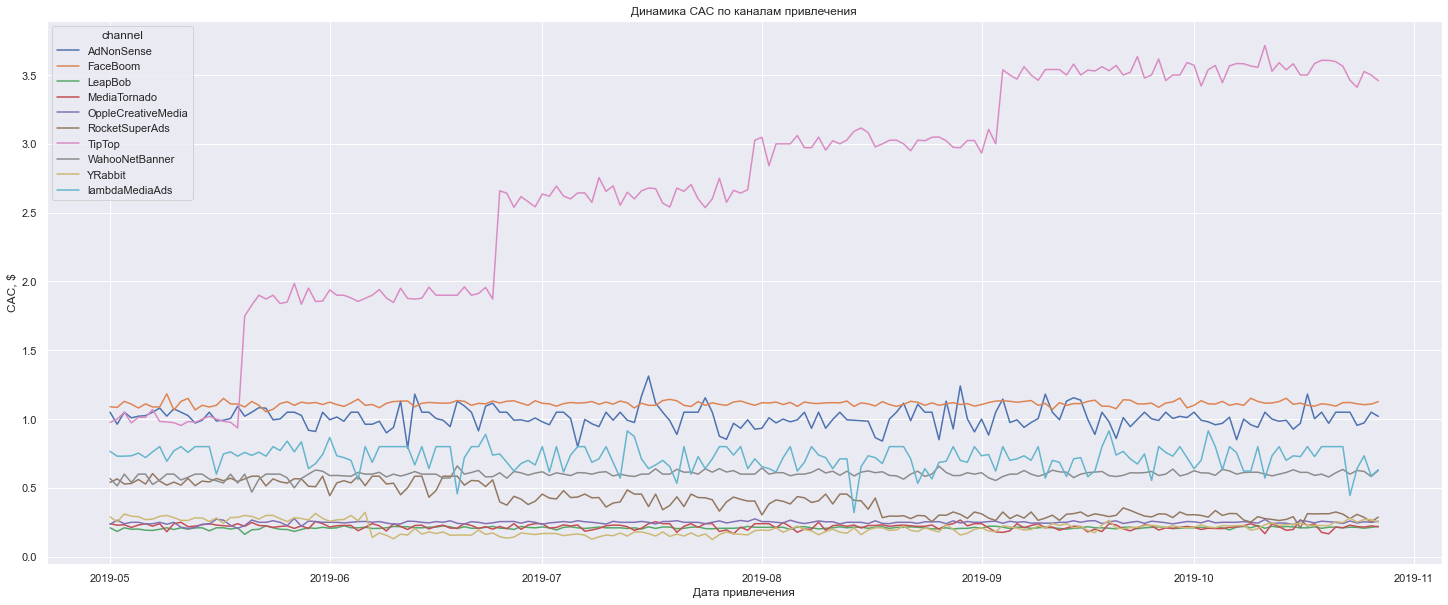

In [34]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(25, 10))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

`TipTop` единственный источник траффика CAC которого стабильно растет на всем наблюдаемом временном интервале. САС остальных источников значительно не менялся, колебания есть, но все они вдоль прямой линии.

### Вывод

* более 80% рекламного бюджета вкладывалось в `FaceBoom` и `TipTop`. Лидером по рекламным инвестициям является  `TipTop` вложения в который стабильно росли и даже превышали `13 000$` в месяц в сентябре
* средний CAC для всех источников для всего проекта составил `1,13$`
* самый высокий CAC `TipTop` `2.8$`, что более чем в два раза выше чем у ближайших конкурентов по этому показателю `FaceBoom` и `AdNonSense` у которых этот показатель чуть выше `1$`
* СAC для `TipTop` стабильно и стремительно увеличивается, для остальных источников колебания незначительны
* CAC остальных источников не превышает 72 центов

Уже можно предположить, что `TipTop` может быть одной из проблем окупаемости компании, но это пока не точно. Более подробно разберемся на следующем шаге.

## Шаг. Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

In [35]:
# задаем момент и горизонт анализа, согласно указаниям в задании
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### Проанализируем общую окупаемость рекламы

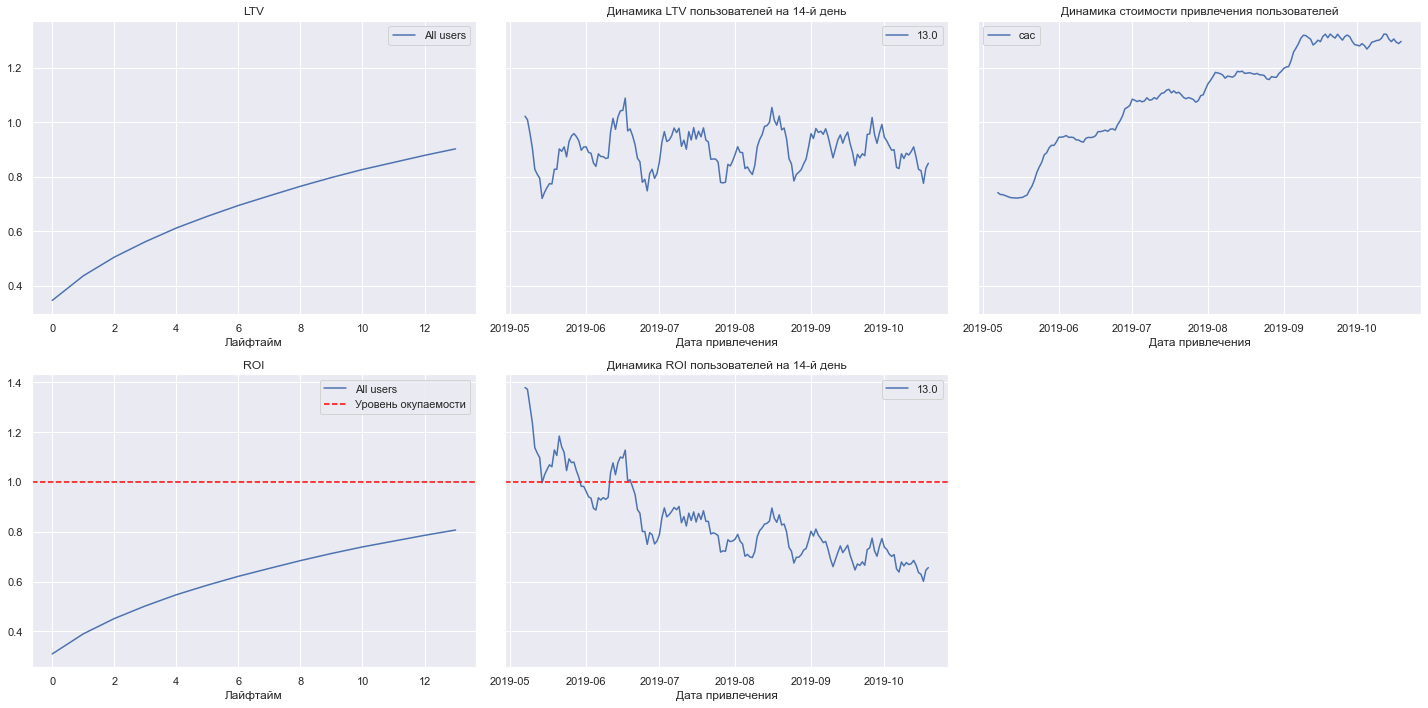

In [36]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:
* реклама не окупается. ROI в конце двух недель доходит только до 80%;
* CAC растет,  значит, увеличение рекламного бюджета играет здесь роль;
* на LTV может влиять сезонный фактор, но этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей;
* ROI пользователей на 14-й день уходит значительно ниже уровня окупаемости - бизнес план не работает! 

В целом картина совсем не радует. Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

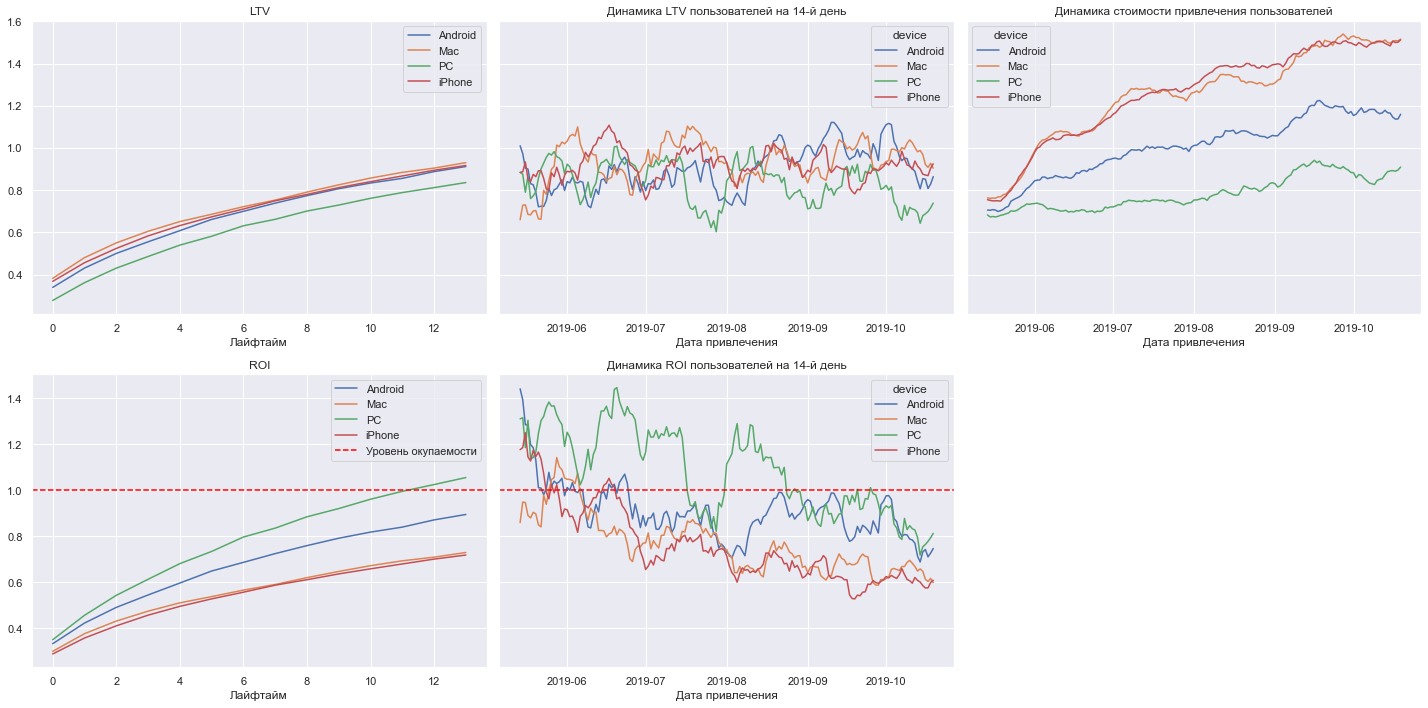

In [37]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

* Стоимость привлечения растет для пользователей всех устройств, но особенно выделяются пользователи Apple (iPhone и MAC), при этом на окупаемость привлечения пользователей этих устройств компания не выходит. Также до окупаемость не достигается для Android-users.  
* динамика ROI на 14-й день для Apple-users также ужастна, Android тоже оставляет желать лучшего. 
* с владельцами PC все не на столько плохо, они выползают на окупаемость, для большинства когорт динамика ROI 14-го дня выше уровня окупаемости 

При этом как мы выяснили ранее основные плательщики это пользователи устройств Apple. Итак на этом шаге видно, что у нас сильно возрасла стоимость привлечения основных платящих пользователей, которых к тому же и в принципе большинство. 

### Проанализируем окупаемость рекламы с разбивкой по странам

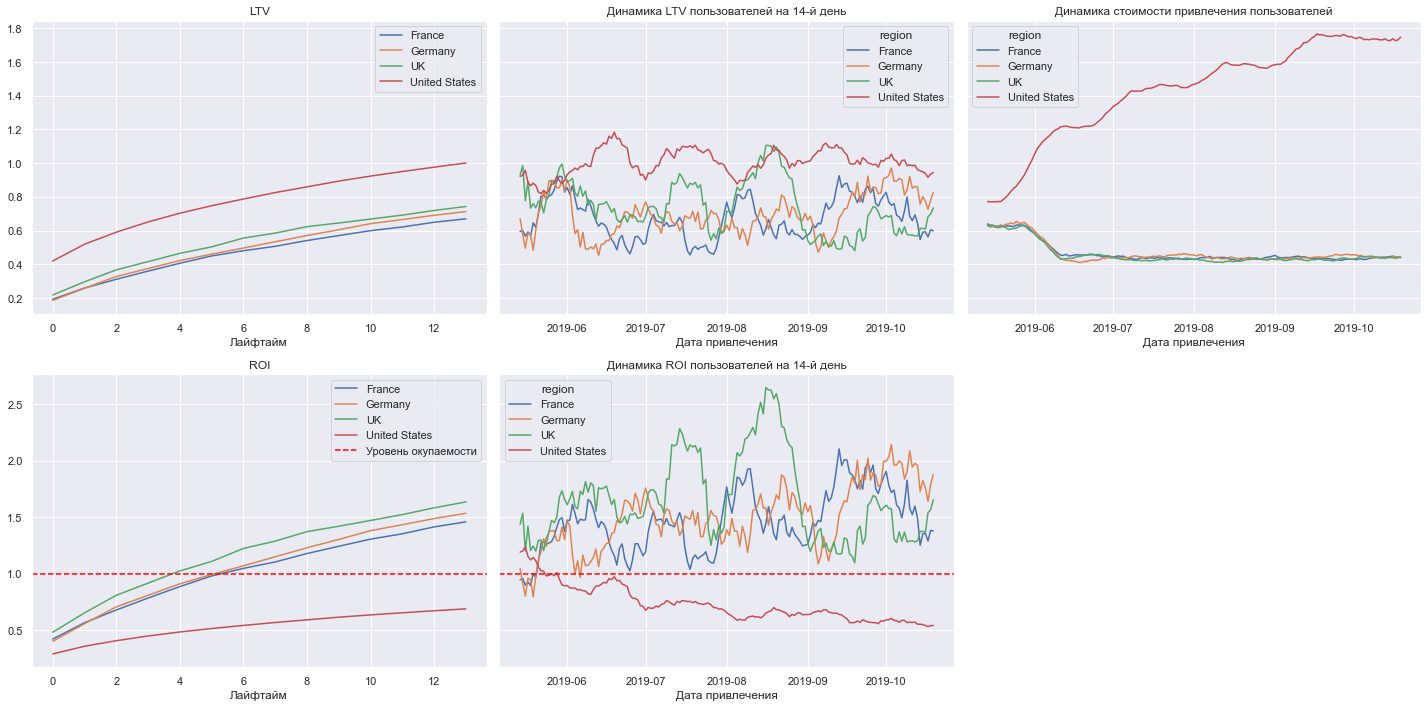

In [38]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Кошмар продолжается
* стоимость привлечения клиентов из США улетает в космос по сравнению с европейскими странами, там в июне стоимость привлечения наоборот снизилась;
* клиенты из США убыточны, ROI приблизительно на уровне 70%, динамика ROI 14 дня уверенно движется в пропасть;
* с Европейскими клиентами все хорошо, стоимость их привлечения снизилась, затем стала стабильной и они окупаются.

Как мы выяснили ранее подавляющее большинство клиентов компании находятся именно в США, поэтому такая картина с их окупаемостью будет серьезно сказываться на финансовом результате компании. 

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

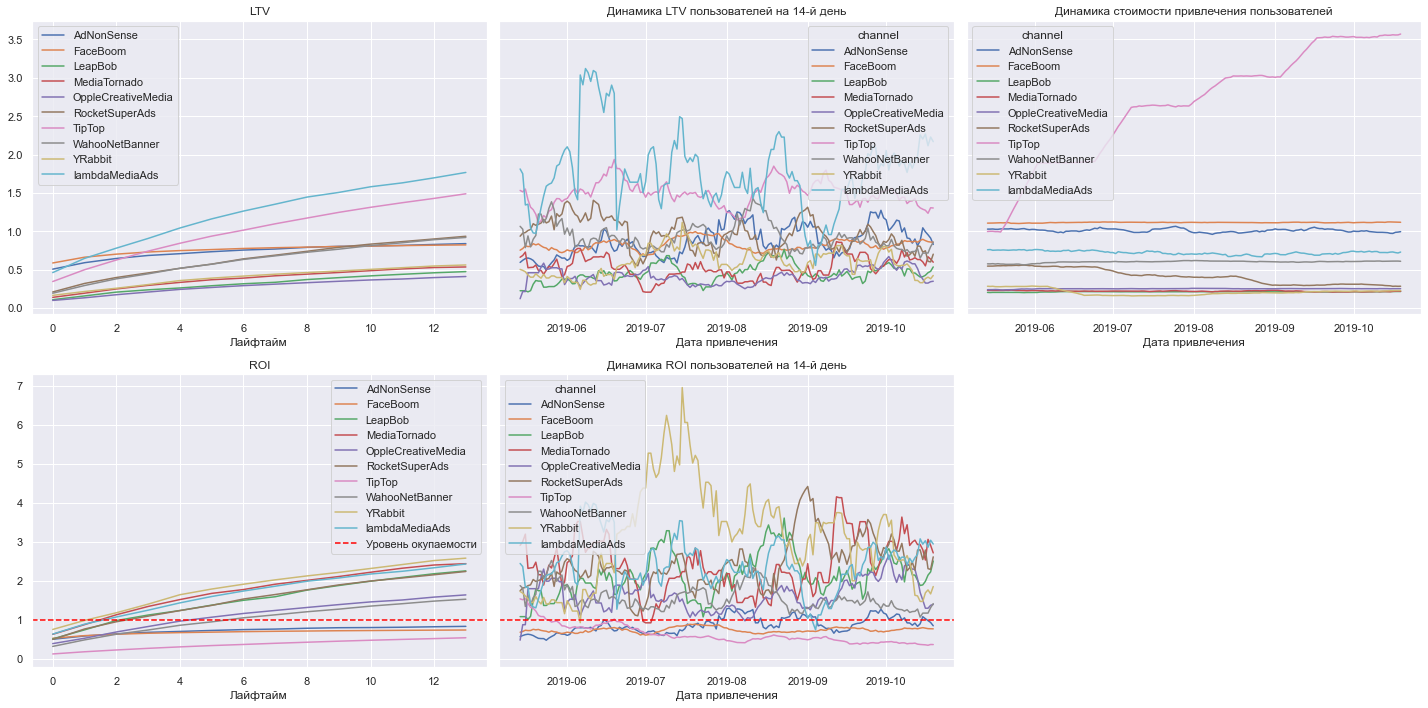

In [39]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

не окупаются следующие каналы привлечения
* `TipTop`, `FaceBoom`, `AddNonSense`

Хуже всего ситуация по `TipTop`, инвестиции туда растут, а окупаемости стабильно нет, ROI у него худший 

* реклама в остальных каналах окупается, лучший показатель окупаемости показывает `YRabbit`

### Анализ окупаемости рекламы в США

In [40]:
profiles_USA = profiles.query("region == 'United States'")

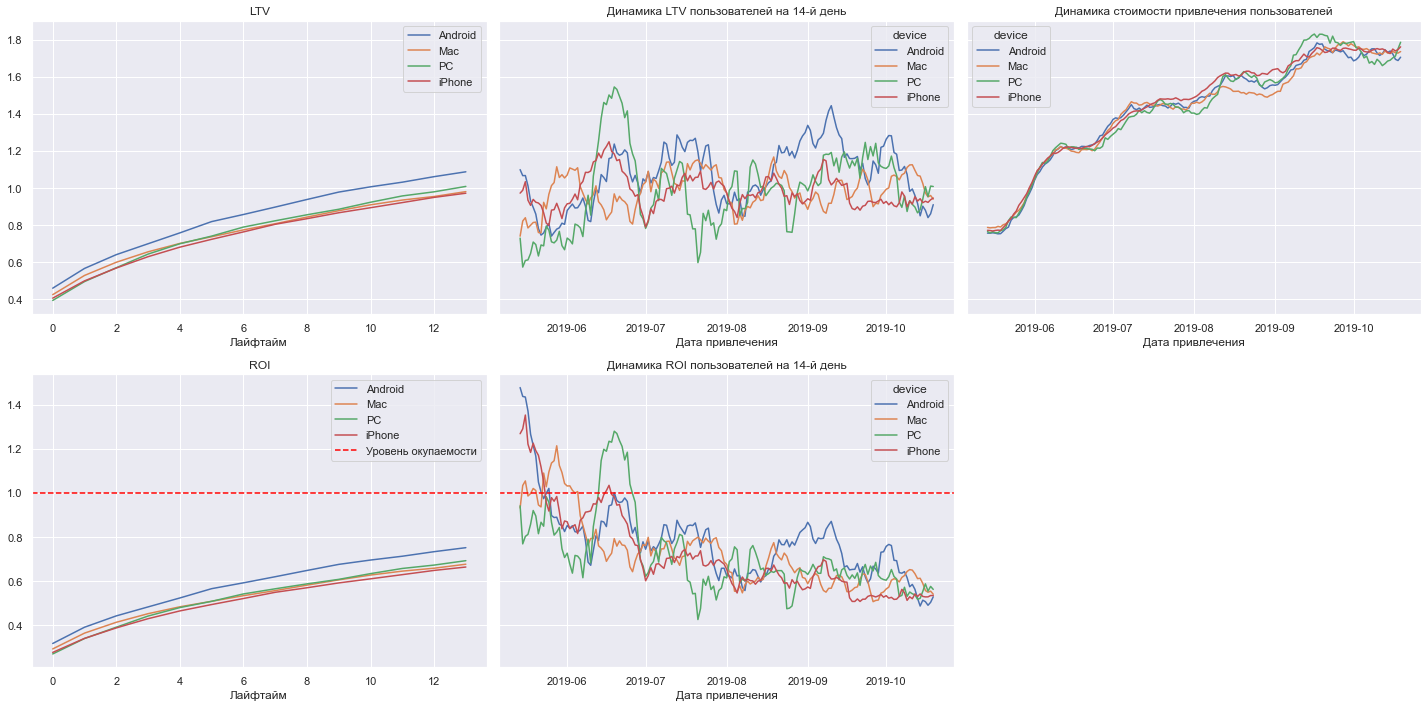

In [41]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_USA, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Рекламные активности в США уводят компанию в убыток.

* стоимость привлечения пользователей всех устройств стабильно и стремительно растет;
* вместе с ней стабильно падает ROI;
* примерно к концу июня CAC вырастает настолько, что ROI всех когорт уходит ниже окупаемости и продолжает стабильно падать
* ROI пользователей Android самый высокий, но и он чуть - чуть не дотягивает даже до 80%, а ROI Apple пользователей, которых большинство только в районе 70%

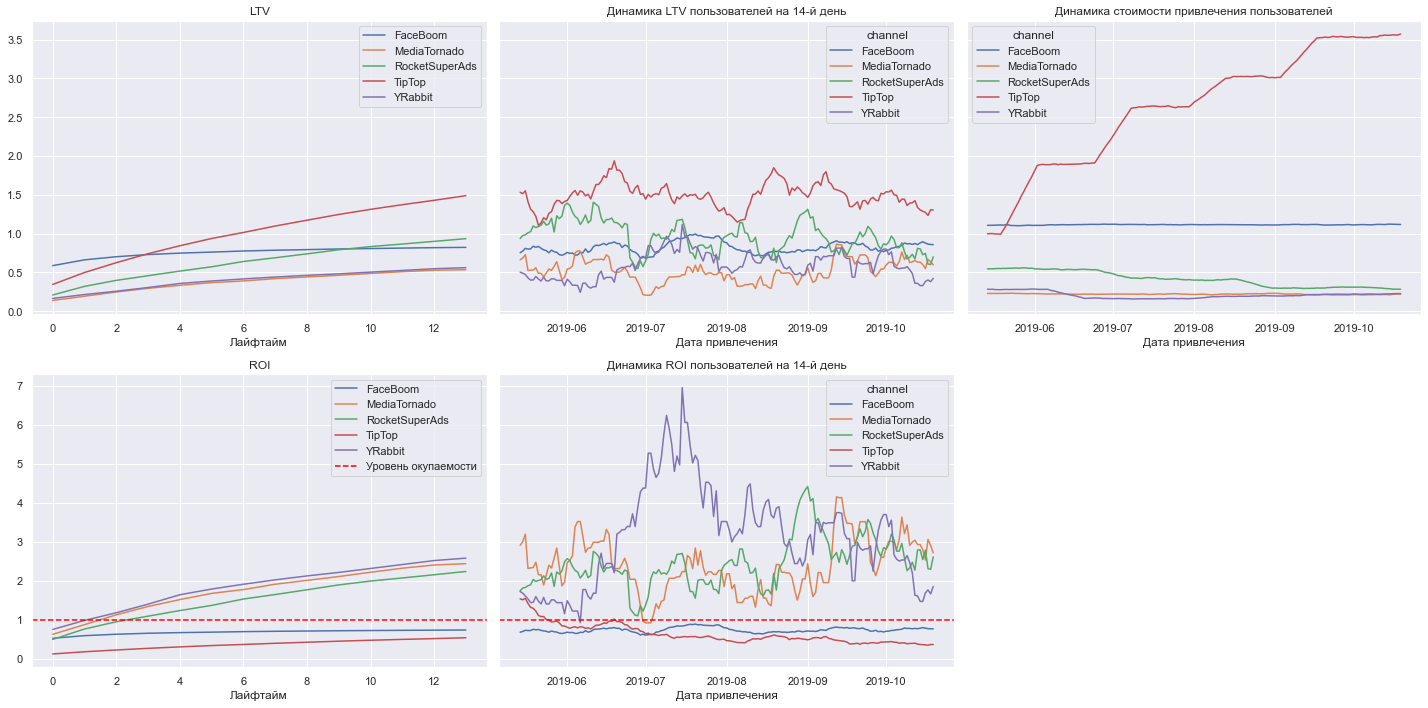

In [42]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_USA, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

в США иcпользуются не все каналы, видимо часть из них по каким-то причинам работают только в Европе... либо маркетинг не стал их задействовать в США.

проблемными являются два рекламных источника `TipTop` и `FaceBoom`, остальные выходят на окупаемость.

### Удержание и конверсия

Построим графики конверсии пользователей и динамики конверсии с разбивкой по устройствам.

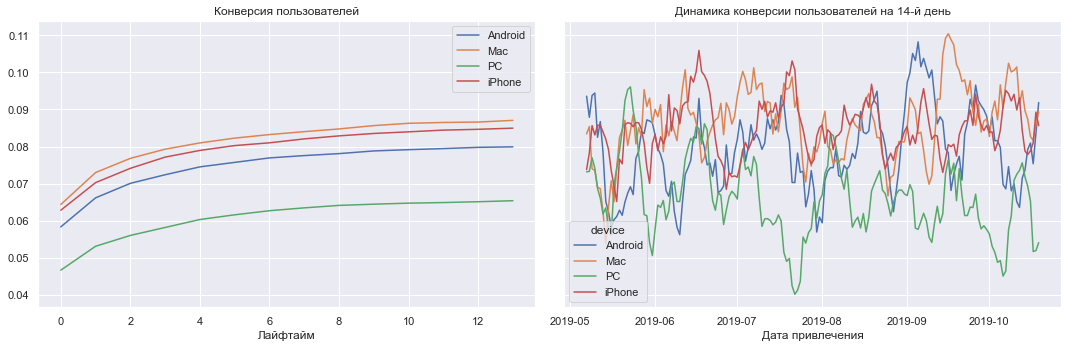

In [43]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Графики подтверждают ранее сделанные выводы, о том, что лучшую конверсию на уровне чуть выше 8,5% показывают пользователи Apple-устройств (MAC и iPhone), немного отстает конверсия для Android-users, а вот c PC этот параметр выглядит довольно печально на фоне остальных около 6.5%. 

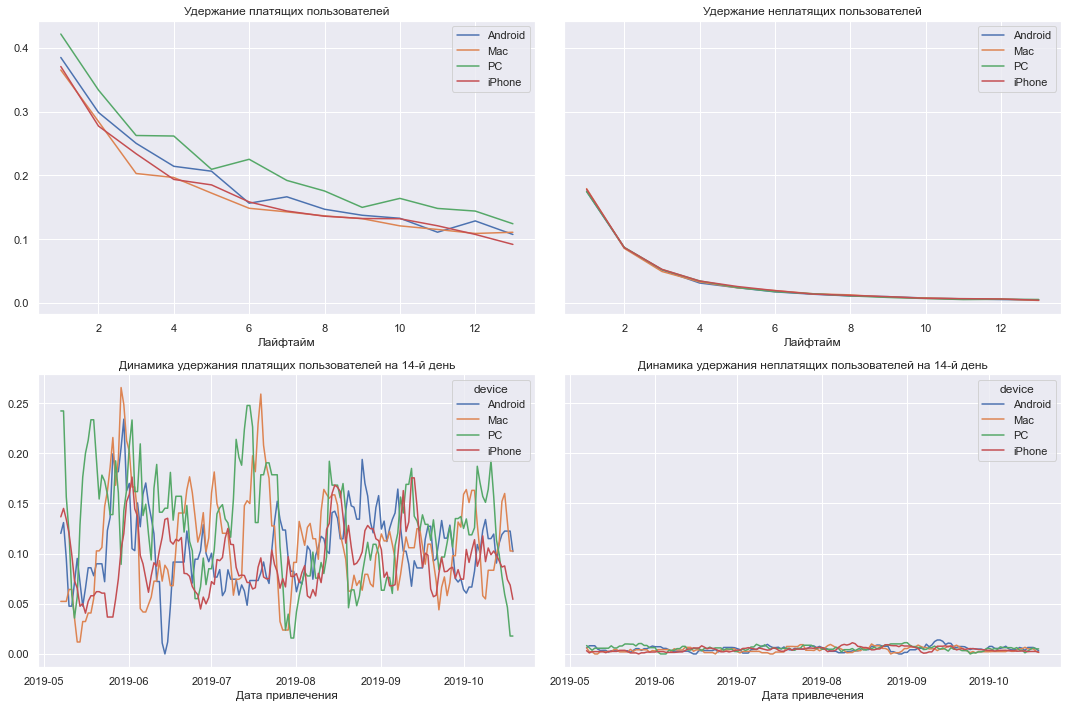

In [44]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

* удержание самых платящих клиентов Apple-users самое низкое, а удержание пользователей с самой низкой конверсией PC-user самое высокое. Хорошо бы наоборот. Хотя в целом процент удержания к 14-му лайфтайму на уровне 9-12% для пользователей всех девайсов, что не так уж и плохо.
* удержание не платящих стабильно невысоко для всех, что в целом естественно

Теперь рассмотрим те же метрики, но с географической разбивкой

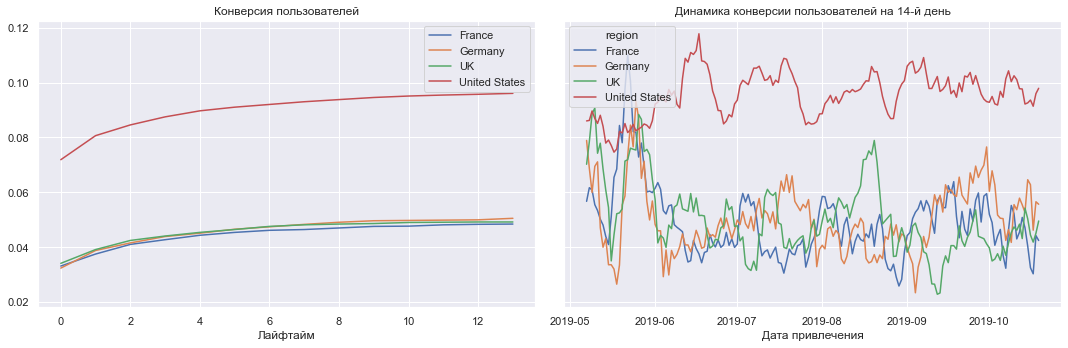

In [45]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия в США (где скорее всего еще и больше всех Apple-usesrs) достигает почти 9%, что на порядок превышает конверсию в европейских странах. А если вспомнить, что у нас еще и клиентов из США в разы больше, то это позволяет смотреть на будущее компании с надеждой.

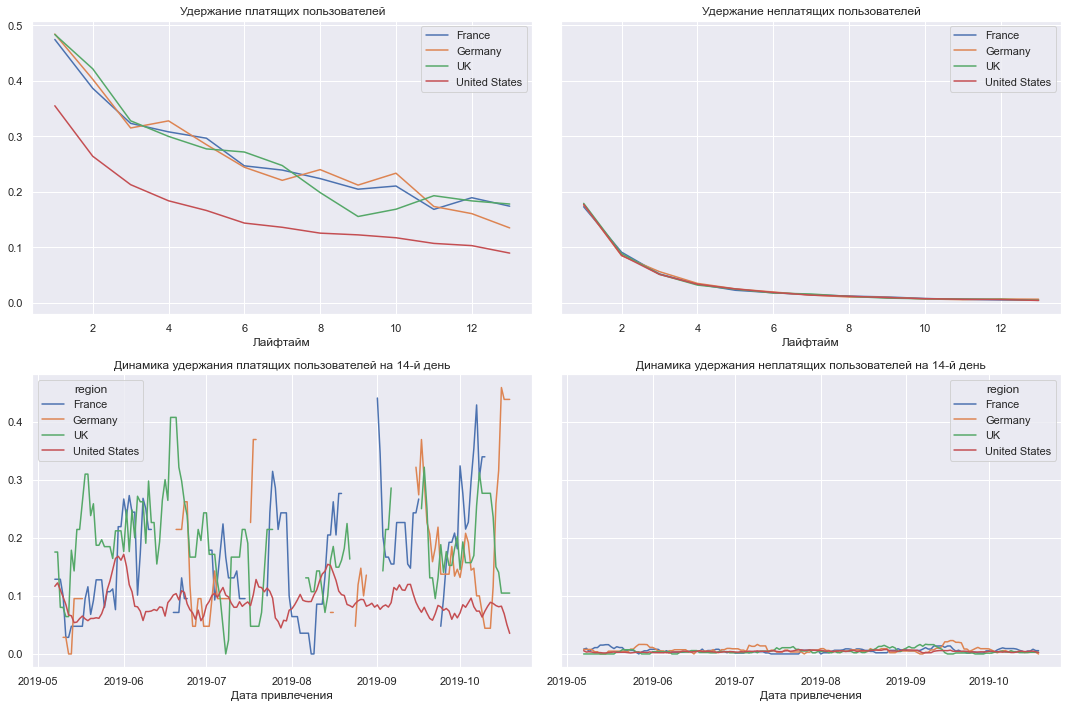

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Только понадеялись на светлое будущее компании, как надежды разбиваются о графики удержания. Если компания может добиваться удержания европейский пользователей на уровне  около 15-18%, то нужно что-то придумывать с повышением удержания американцев, которое к 14-му лайф тайму не дотягивает до 10. Динамика удержания 14го дня наших приоритетных клиентов из США также достаточно низкая. 

Теперь разбивка по каналам привлечения.

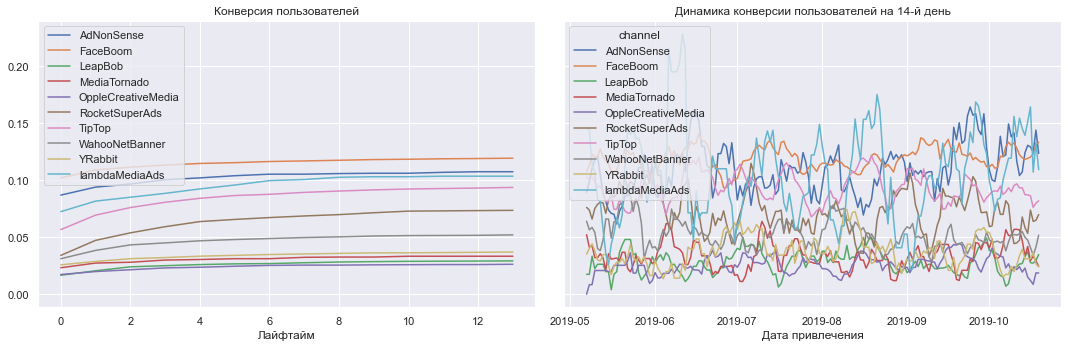

In [47]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Как отмечали ранее, лидеры по конверсии `FaceBoom`, `AdNonSense`, `LambdaMediaAds`,`TipTop`, `RocketSuperAds`.
Интересно, что наш самый дорогой `TipTop` лишь на 4-м месте в этом рейтинге.

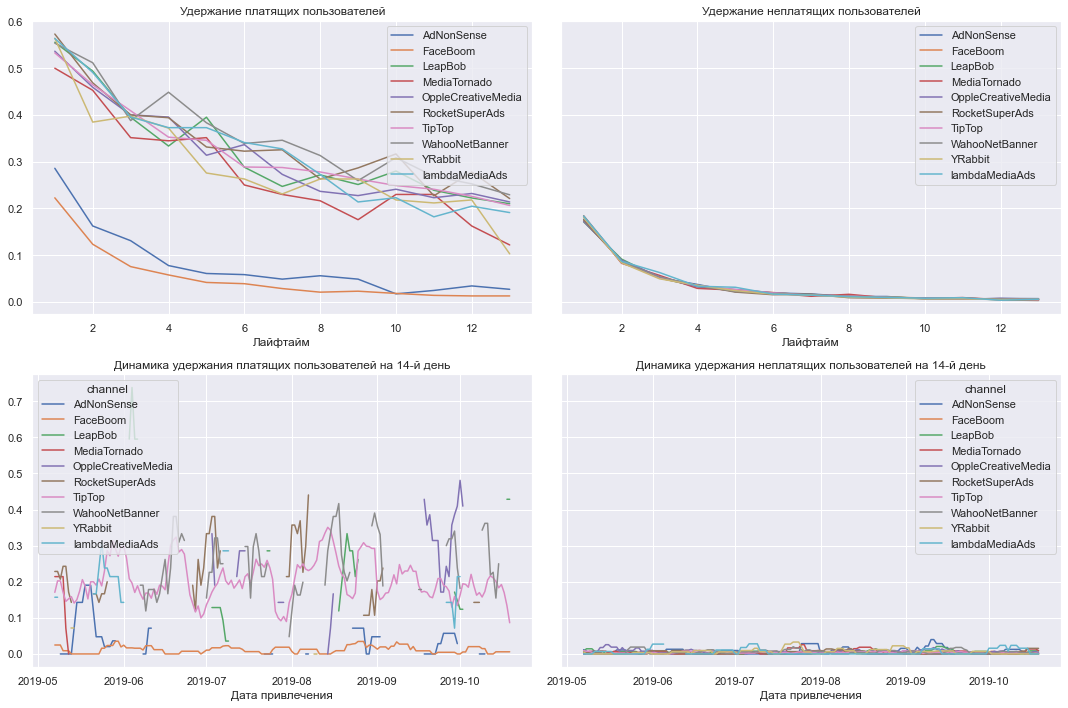

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Лидеры по привлечению = аутсайдеры по удержанию, получается через `FaceBoom`, `AdNonSense` мы получаем совсем "коротких" клиентов.
`LambdaMediaAds`вновь заслуживает внимания, удержание на уровне почти 20% при конверсии выше 10% делает ее довольно интересной.

### Удержание и конверсия в США

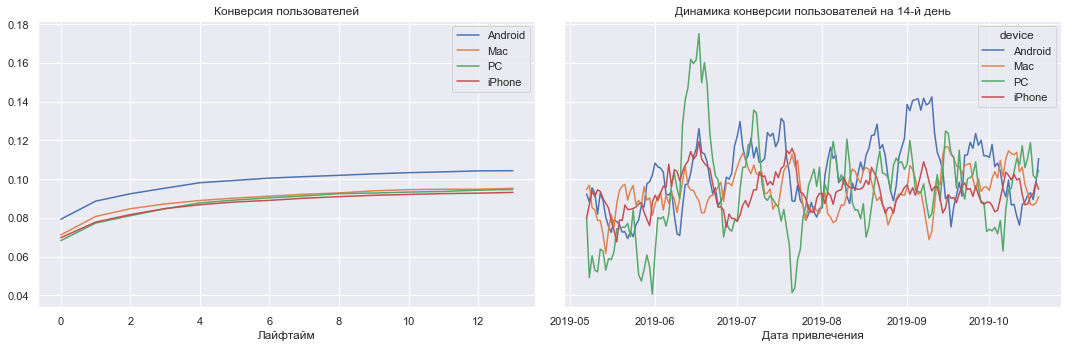

In [49]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_USA, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

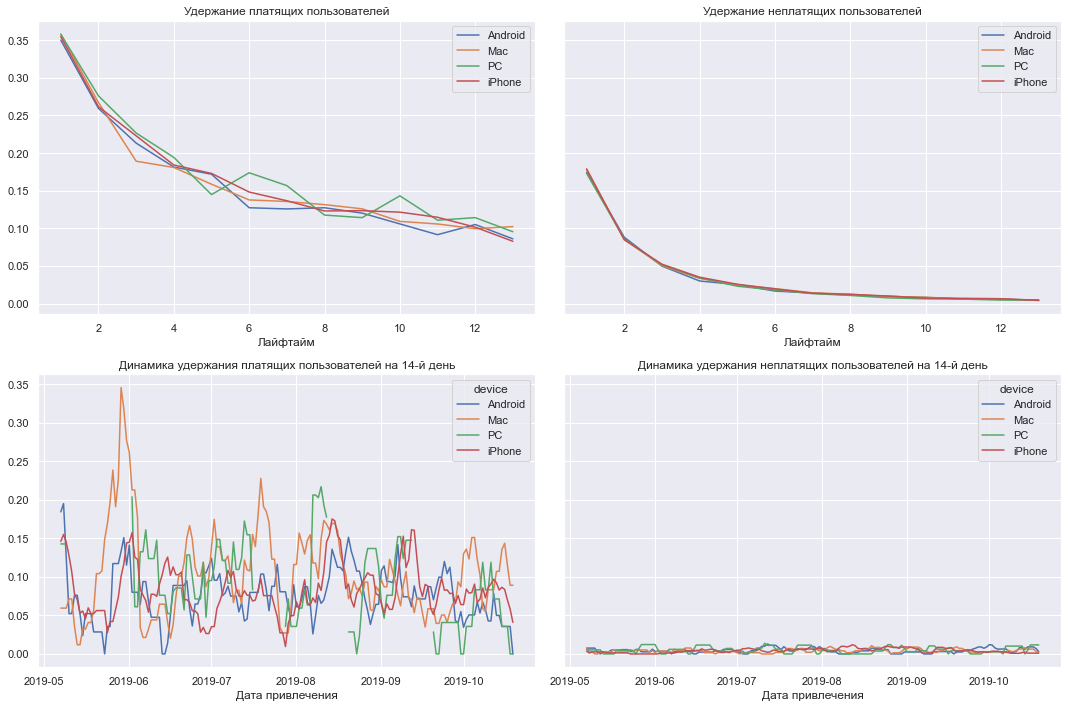

In [50]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_USA, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Проверка конверсии и удержания клиентов США с разбивкой по устройвам не выявляет каких - то аномалий для пользователей разных устройств. Конверсия Android - users чуть лучше, удержание у всех на одном уровне в районе 10 % к 14-му дню, что не плохо.

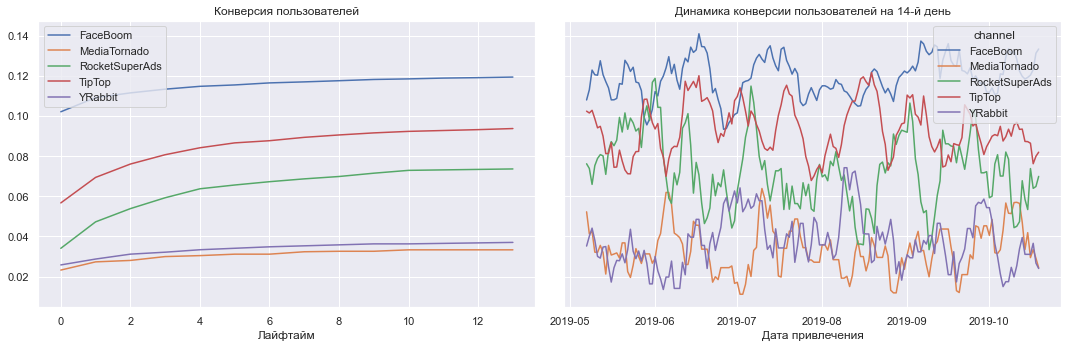

In [51]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_USA, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

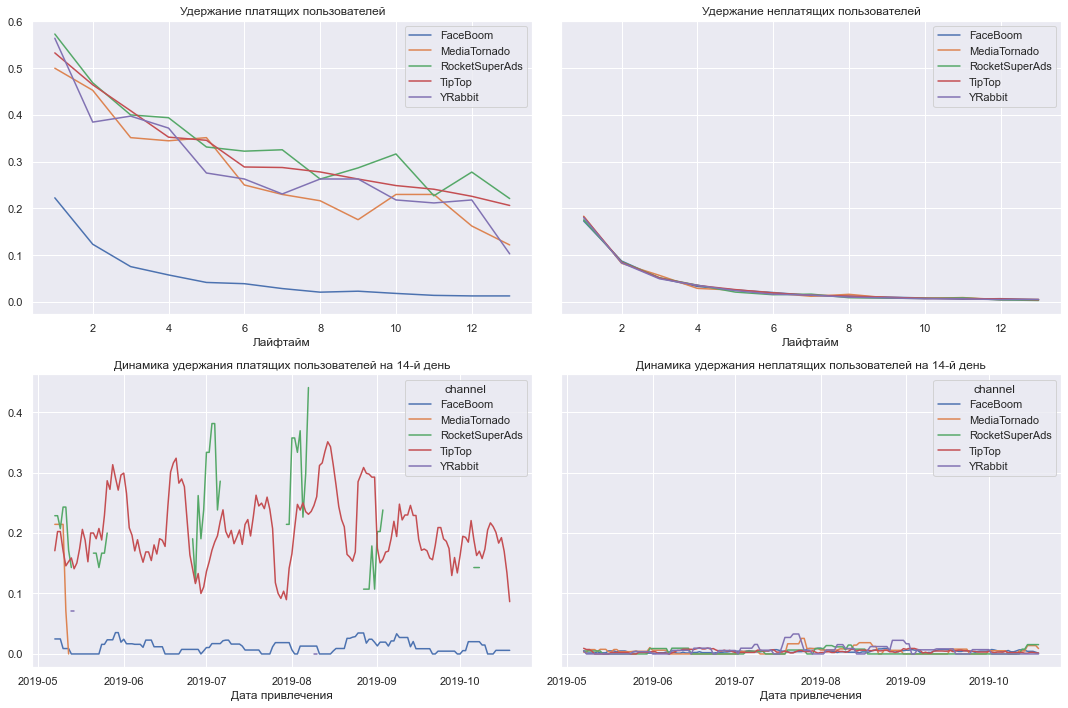

In [52]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_USA, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

удержание и конверсия в разбивке по рекламным каналам для американцев приципиально не отличается от общей картины.
запомним `RocketSuperAds` c неплохой конверсией и лучшим удержанием.

### Вывод

* лучшая конверсия у пользователей Apple устройств из США;
* при этом у них же и самый плохой показатель удержания;
* лидеры по конверсии `FaceBoom`, `AdNonSense`, `LambdaMediaAds`,`TipTop`, `RocketSuperAds`, однако `FaceBoom`, `AdNonSense`показывают плохие значения по удержанию.

Резльтат анализа окупаемости рекламы следующий:

* в целом реклама не окупается, ROI едва дотягивает до 80%;
* окупаются только пользователи PC, а вот Android и Apple users убыточны, при этом последние еще и составляют абсолютное большинство клиентской базы;
* имеются три канала привлечения, которые являются убыточными, это `TipTop`, `FaceBoom`, `AddNonSense`, при этом `TipTop`, `FaceBoom`являются абсолютными лидерами по инвестициям, да еще и инвестиции в `TipTop` стабильно росли;
* пользователи из Европы стабильно выходят на окупаемость, но вот только подавляющее число клиентов из США и они являются убыточными, скорее всего за счет высокой стоимости привлечения.





## Шаг 6. Общий вывод
- Выделим причины неэффективности привлечения пользователей;
- Сформируем рекомендации для отдела маркетинга для повышения эффективности.

В данной работе были проанализированы данные о пользователях компании по приложению `Procrastinate+` c 1.05 по 27.10.2019 года
За данный период компания инвестировала в рекламу сумму порядка `105 000$`, однако потерпела убытки. Мы провели анализ расходов и окупаемости в разрезе по странам, устройствам и каналам, подробные выводы описаны выше. 

Большинство клиентов данной компании проживают в США и являются пользователями устройств компании Apple, к сожалению несмотря на хороший показатель конверсии этих клиентов именно они и являются убыточными в первую очередь за счет дорогого привлечения. 
Люди проживающие в Европе пусть и в значительно меньшем количестве тоже являются клиентами компании, с их окупаемостью все в порядке.


Итак, сформулируем возможные причины проблем и рекомендации для рекламного отдела.

 * основной причиной убытков видятся завышенные расходы на привлечение пользователей из США, которые, увы не окупились, даже несмотря на хорошую конверсию и большое количество пользователей. 
 * особенно необходимо обратить внимание на инвестиции в канал `TipTop`, исходя из вышесказанного он лидер по убыточности и инвестиции в него стоит сокращать в первую очередь, также нужно подумать о целесообразности небольшого сокращения инвестиций в `FaceBoom`, `AdNonSense` - уж очень плохое удержание 
 * можно обратить внимание на канал `LambdaMediaAds`, который показывает не плохие значения конверсии, удержания, ROI. 
 * еще хорошо себя показывает канал `RocketSuperAds` неплохая конверсия и отличное удержание по сравнению с остальными.
 
Европейский рынок выглядит недоосвоенным, клиенты из Европейских стран демонстрирует ROI стабильно выше окупаемости, но их число в сравнении с американцами незначительно.

Ощущается явный перекос рекламных вложений в пользу Apple-users, вероятно стоит чуть больше внимания уделить пользователям PC и Android. Делать это нужно осторожно, для начала небольшими вложениями, т.к. сейчас их ROI выше за счет более низкого CAC, а что будет после увеличения объемов рекламы пока сказать сложно

Отдельного анализа требует "пользовательский путь" organic клиентов, их много, но конвертация на низком уровне, к сожалению эта часть пока выходит за рамки текущего исследования.
